In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import math
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from torch.autograd.functional import jvp
from tqdm import tqdm

from deltamodel import VectorFieldOperation, DeltaModel, compute_coords_weight, LipschitzLoss
from utils import grid_sample, plot_delta, plot_delta_instance, MetricTracker, plot_coords_weight

from torchdiffeq import odeint_adjoint as odeint
from resnet import resnet18

device = 'cuda'

resnet = resnet18()
model = nn.Sequential(resnet.conv1,
                    resnet.conv2_x,
                    resnet.conv3_x,
                    resnet.conv4_x,
                    resnet.conv5_x,
                    resnet.avg_pool,
                    nn.Flatten(1,-1)
)
rgb_normalize = ()


model.eval()
model = model.to(device)
for p in model.parameters():
    p.requires_grad = False

# load dataset
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # no transform for visualization
    ])

train_dataset = datasets.CIFAR10(root='./data/cifar10', train=True,
                                        download=True, transform=transform)
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)


exp_name = 'exp20241028135112'
# define vfop
img_size = 32
def model_normalized(x):
    return F.normalize(model(x))
coords_weight = torch.load(os.path.join('experiment-symmetry_learning',exp_name,'coords_weight.pt'),map_location = device)
vfop = VectorFieldOperation(img_size,coords_weight, device = device)
coords = vfop.coords





n_delta = 10

delta_model = DeltaModel(vfop = vfop, n_delta = n_delta)

delta_model = delta_model.to(device)
delta_model.load_state_dict(torch.load(f'experiment-symmetry_learning/{exp_name}/deltamodel.pt',map_location=device))



Files already downloaded and verified


/tmp/ipykernel_23556/2558384749.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coords_weight = torch.load(os.path.join('experiment-symmetry_learning',exp_name,'coords_

<All keys matched successfully>

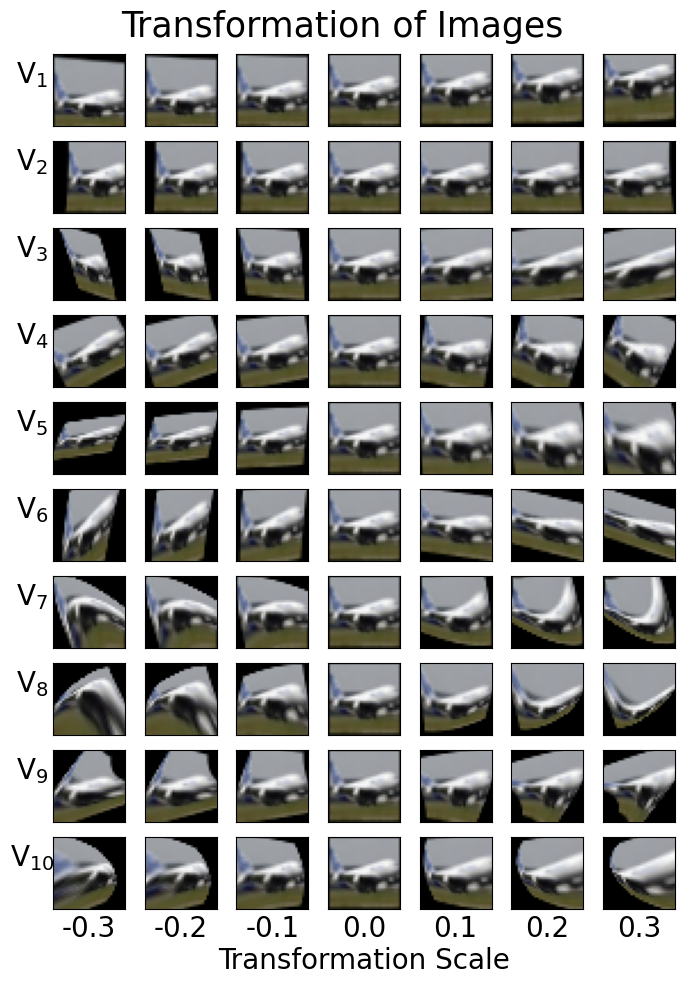

In [17]:
idx = 44884

with torch.no_grad():
    coords_transformed = coords.unsqueeze(3).repeat(1,1,1,n_delta).contiguous()
    t_final = 0.3
    n_interval = 7
    interval = torch.linspace(0,t_final,n_interval // 2 + 1).to(device,torch.float32)

    coords_transformed_1 = odeint(lambda t,x:delta_model(x),
                                coords_transformed,
                                interval,
                                adjoint_params=delta_model.parameters(),
                                method = 'rk4',
                                options = {'step_size' : sigma/20.})
    
    interval = torch.linspace(0,-t_final,n_interval // 2 + 1).to(device,torch.float32)

    coords_transformed_2 = odeint(lambda t,x:delta_model(x),
                                coords_transformed,
                                interval,
                                adjoint_params=delta_model.parameters(),
                                method = 'rk4',
                                options = {'step_size' : sigma/20.})[1:].flip(0)
    coords_transformed = torch.cat([coords_transformed_2,coords_transformed_1],dim=0)
    coords_transformed = coords_transformed.permute(4,0,1,2,3).flatten(0,1).cpu()
    interval = torch.linspace(-t_final,t_final,n_interval)

    for _ in range(1):

        # idx = np.random.randint(len(train_dataset))
        data , _ = train_dataset[idx]
        data_repeat = data.unsqueeze(0).repeat(n_delta * n_interval,1,1,1)
        data_transformed = F.grid_sample(data_repeat,coords_transformed)
        data_transformed = data_transformed.view(n_delta,n_interval,3,img_size,img_size)

        fig,axes = plt.subplots(nrows = n_delta ,ncols = n_interval, figsize=(7,10))
        # fig,axes = plt.subplots(nrows = n_interval ,ncols = n_delta , figsize=(10,7))
        params = {'mathtext.default': 'regular' }          
        plt.rcParams.update(params)
        for i in range(n_interval):
            for j in range(n_delta):
                ax = axes[j,i]
                plt.sca(ax)
                plt.imshow(data_transformed[j,i].permute(1,2,0))
                # plt.axis('off')
                ax.get_xaxis().set_ticks([])
                ax.get_yaxis().set_ticks([])
                if j==9:
                    # ax.set_xlabel(f'{interval[i]:.1f}',fontsize=20)
                    # ax.xaxis.set_label_position('top') 
                    if i==3:
                        ax.set_xlabel(f'{interval[i]:.1f}\nTransformation Scale',fontsize=20)
                    else:
                        ax.set_xlabel(f'{interval[i]:.1f}',fontsize=20)
                    ax.xaxis.set_label_position('bottom') 
                if i==0:
                    # ax.set_ylabel(f'V{j+1}',fontsize=20)
                    ax.set_ylabel(f'$V_{{{j+1}}}$',fontsize=20, rotation=0, labelpad=15)
                    # ax.xaxis.set_label_position('top') 
                    
                    
                # if i==0:
                #     axes[j,i].set_xlabel("j")
                # if i==0:
                #     axes[j,i].set_ylabel("i")
        # fig.suptitle('transformation scale', fontsize=20)
        fig.suptitle('Transformation of Images',fontsize=25)
        fig.tight_layout()
        plt.show(fig)

        plt.close(fig)

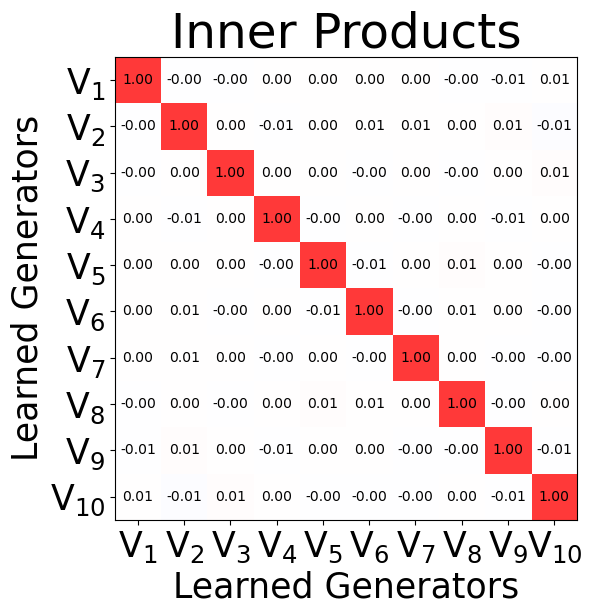

In [22]:
delta = delta_model(coords.unsqueeze(3).repeat(1,1,1,n_delta))
ortho_loss_each = vfop.sequential_ortho_loss(delta,final='arccos')
ip = vfop.inner_product(delta,delta).detach().cpu()


plt.figure(figsize=(6.25,6.25))
plt.imshow(ip,cmap = 'bwr', vmax = 1.3, vmin = -1.3)
params = {'mathtext.default': 'regular' }
for i in range(n_delta):
    for j in range(n_delta):
        plt.text(i,j,'{:.2f}'.format(ip[i,j]),ha='center', va='center',fontsize=10)
plt.xticks(range(n_delta),[f'$V_{{{i+1}}}$' for i in range(n_delta)],fontsize=25)
plt.yticks(range(n_delta),[f'$V_{{{i+1}}}$' for i in range(n_delta)],fontsize=25)
plt.ylabel('Learned Generators',fontsize = 25)
plt.xlabel('Learned Generators',fontsize = 25)
plt.title('Inner Products',fontsize = 35)
plt.tight_layout()
plt.show()
plt.close()

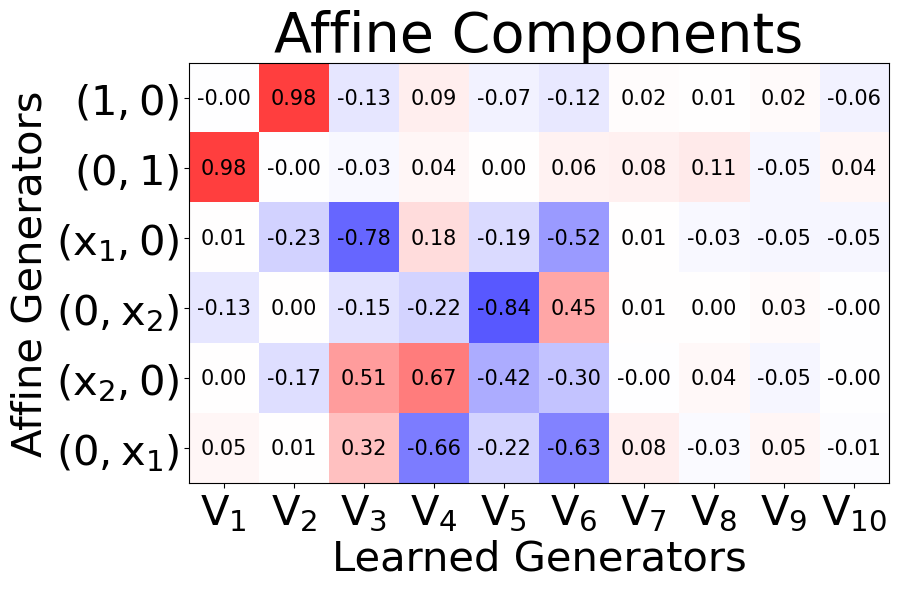

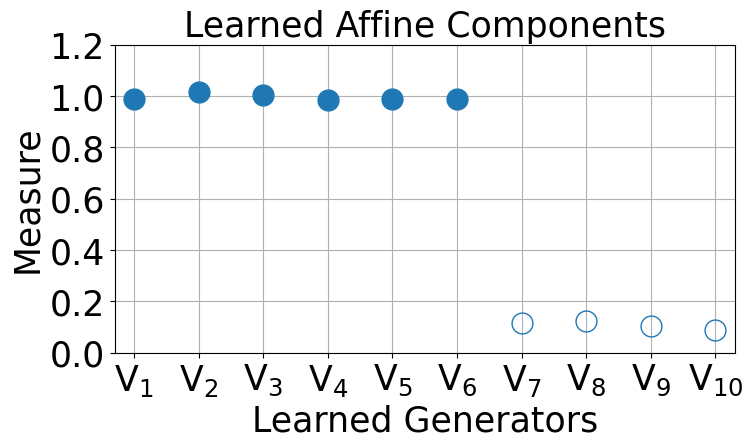

In [23]:
delta_affine = vfop.get_affine_basis()
delta = delta_model(coords.unsqueeze(3).repeat(1,1,1,n_delta))

affine_components = vfop.inner_product(delta,delta_affine).detach().cpu()
n_affine = 6
affine_names = [
    '$(1,0)$',
    '$(0,1)$',
    '$(x_1,0)$',
    '$(0,x_2)$',
    '$(x_2,0)$',
    '$(0,x_1)$',
]
plt.figure(figsize=(10,6))
plt.imshow(affine_components.T,cmap = 'bwr', vmax = 1.3, vmin = -1.3)
# plt.imshow(affine_components.T,cmap = 'coolwarm', vmax = 1, vmin = -1)
for i in range(n_delta):
    for j in range(n_affine):
        plt.text(i,j,'{:.2f}'.format(affine_components[i,j]),ha='center', va='center',fontsize=15)
plt.ylabel('Affine Generators',fontsize = 30)
plt.xlabel('Learned Generators',fontsize = 30)
plt.xticks(range(n_delta),[f'$V_{{{i+1}}}$' for i in range(n_delta)],fontsize=30)
plt.yticks(range(n_affine),affine_names,fontsize=30)
plt.title('Affine Components',fontsize = 40)
plt.tight_layout()
plt.show()
plt.close()

affine_norms = (affine_components**2).sum(axis=1) ** 0.5
plt.figure(figsize=(8,4))
plt.plot(np.arange(0,6), affine_norms[:6],'o',markersize=15)
plt.plot(np.arange(6,10), affine_norms[6:],'o',markersize=15,fillstyle = 'none',color = 'tab:blue')
plt.grid()
plt.ylim(0,1.2)
plt.xlim(-0.3,n_delta-0.7)
plt.xticks(range(n_delta),[f'$V_{{{i+1}}}$' for i in range(n_delta)],fontsize=25)
plt.yticks(np.linspace(0,1.2,7),fontsize=25)

plt.ylabel('Measure',fontsize=25)
plt.xlabel('Learned Generators',fontsize=25)
plt.title('Learned Affine Components',fontsize=25)

plt.show()
plt.close()
